In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

usarrests = pd.read_csv('data/USArrests.csv', index_col=0)

In [60]:
usarrests.head()
# usarrests.colum

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [61]:
from sklearn.preprocessing import scale

usarr_scaled = pd.DataFrame(scale(usarrests), 
                            columns=usarrests.columns)

In [62]:
usarr_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


In [63]:
pca = PCA(n_components=4)
pca.fit(usarr_scaled)

X_pca = pca.transform(usarr_scaled)
print("원본 데이터 형태: {}".format(str(usarr_scaled.shape)))
print("축소된 데이터 형태: {}".format(str(X_pca.shape)))

원본 데이터 형태: (50, 4)
축소된 데이터 형태: (50, 4)


Text(0,0.5,'두 번째 주성분')

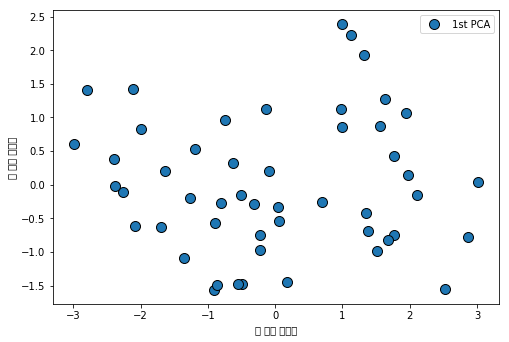

In [64]:
import mglearn

plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1])
plt.legend(["1st PCA", "2nd PCA"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("첫 번째 주성분")
plt.ylabel("두 번째 주성분")

In [65]:
print("PCA 주성분 형태: {}".format(pca.components_.shape))

PCA 주성분 형태: (4, 4)


In [66]:
print("PCA 주성분:\n{}".format(pca.components_))

PCA 주성분:
[[ 0.53589947  0.58318363  0.27819087  0.54343209]
 [ 0.41818087  0.1879856  -0.87280619 -0.16731864]
 [-0.34123273 -0.26814843 -0.37801579  0.81777791]
 [ 0.6492278  -0.74340748  0.13387773  0.08902432]]


### scree plot와 Cumulative plot 그리고 각 PC의 갯수별 variance

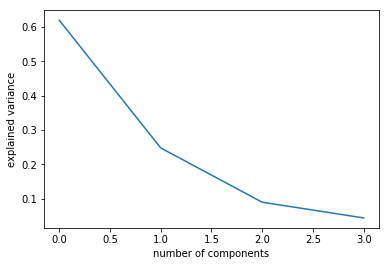

In [67]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

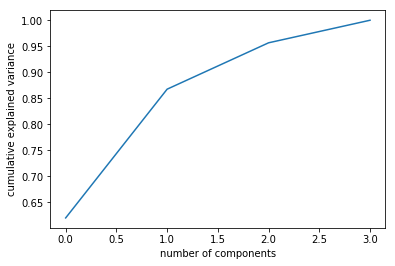

In [68]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

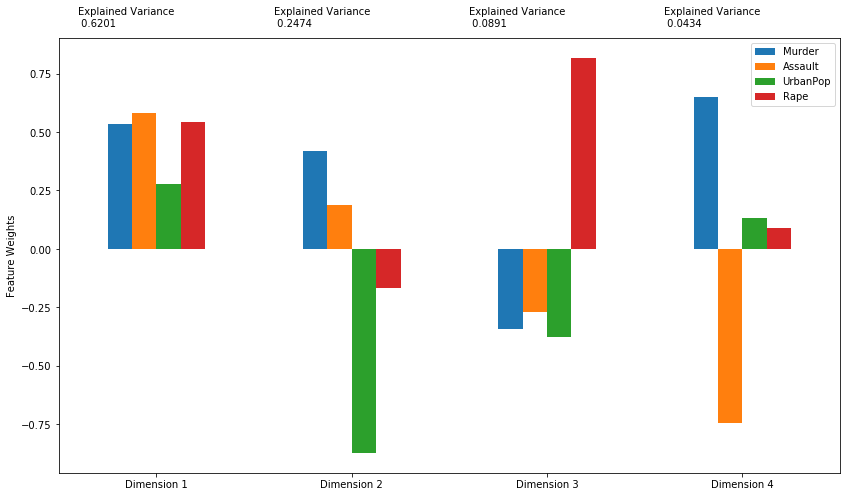

In [69]:
def pca_results(data, pca):
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(usarr_scaled, pca)

In [70]:
pca_results.cumsum()


,Explained Variance,Murder,Assault,UrbanPop,Rape
Dimension 1,0.6201,0.5359,0.5832,0.2782,0.5434
Dimension 2,0.8675,0.9541,0.7712,-0.5946,0.3761
Dimension 3,0.9566,0.6129,0.5031,-0.9726,1.1939
Dimension 4,1.0000,1.2621,-0.2403,-0.8387,1.2829


### 4차원일때 Kmeans를 돌려서 구집화해보기. 특정 k를 선택한 이유를 설명하고 실제 k로 나눈 후에 각 클러스터별 특성 파악

In [71]:
from mpl_toolkits.mplot3d import Axes3D

X = usarr_scaled

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
# print("클러스터 레이블:\n{}".format(kmeans.labels_))
y_kmeans = kmeans.predict(X)
print(y_kmeans)

# centers = kmeans.cluster_centers_
# centers

[2 2 2 1 2 2 0 0 2 2 0 1 2 0 1 0 1 2 1 2 0 2 1 2 2 1 1 2 1 0 2 2 2 1 0 0 0
 0 0 2 1 2 2 0 1 0 0 1 1 0]


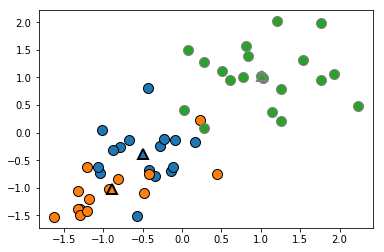

In [72]:
import mglearn

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers='^', markeredgewidth=2)

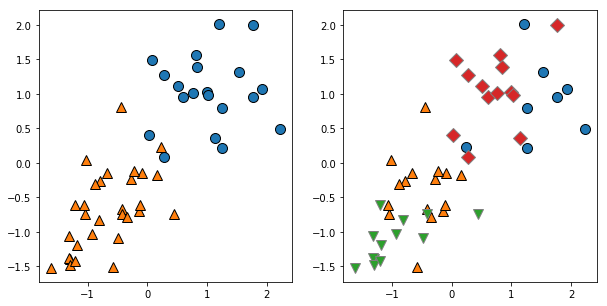

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 두 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[0])

# 다섯 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[1])

### 2차원으로 축소한 후 축소된 2차원의 Score Vector에 다시 kmeans를 돌려 군집하고 해석하기

In [74]:
data = usarr_scaled
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
# pca_samples = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

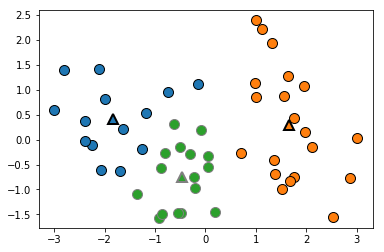

In [75]:
X = reduced_data
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers='^', markeredgewidth=2)

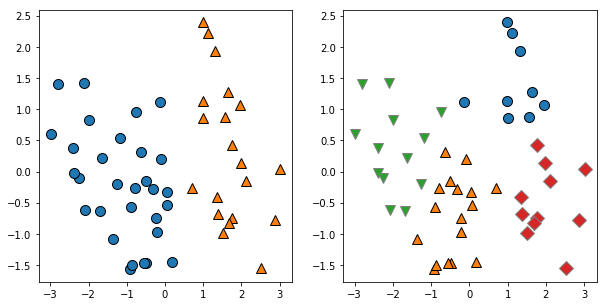

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 두 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[0])

# 다섯 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[1])